In [1]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score, roc_auc_score, log_loss

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import time
import csv
import shap


#load the preprocessed data
X_train = pd.read_csv("X_train_bin.csv")
X_test = pd.read_csv("X_test_bin.csv")
y_train = pd.read_csv("y_train_bin.csv").squeeze()
y_test = pd.read_csv("y_test_bin.csv").squeeze()

In [2]:
#dataframes to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [3]:
#Load the data to gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

In [4]:
num_layers = 4
hidden_sizes = [107, 20, 109, 60]
dropout = 0.2725519019624006
lr = 0.0002363411909183287
batch_size = 256
optimizer_name = 'Adam'  # Using Adam optimizer as per the params
num_epoch = 10

In [5]:
# Define model architecture
layers = []
in_features = X_train.shape[1]  # This should be defined earlier in your code

for i in range(num_layers):
    out_features = hidden_sizes[i]
    layers.append(nn.Linear(in_features, out_features))
    layers.append(nn.ReLU())
    layers.append(nn.Dropout(dropout))
    in_features = out_features

layers.append(nn.Linear(in_features, 1))  # Output layer

mlp_model = nn.Sequential(*layers).to(device)  # Ensure `device` is defined, e.g., torch.device("cuda" or "cpu")

In [6]:
#define loss function for binary classification
loss_fn = nn.BCEWithLogitsLoss()

# Create the optimizer based on the variable `optimizer_name`
if optimizer_name == "Adam":
    optimizer = optim.Adam(mlp_model.parameters(), lr=lr)
elif optimizer_name == "SGD":
    optimizer = optim.SGD(mlp_model.parameters(), lr=lr)
elif optimizer_name == "RMSprop":
    optimizer = optim.RMSprop(mlp_model.parameters(), lr=lr)
else:
    raise ValueError(f"Unsupported optimizer: {optimizer_name}")

In [7]:
#train and test sets loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
#training phase

start_time = time.perf_counter()
for epoch in range(num_epoch):
    mlp_model.train()
    for inputs, labels in train_loader:
        #fix input dimensions
        inputs = inputs.view(inputs.size(0), -1)

        #load data to the same device as the model
        inputs.to(device)
        labels = labels.to(device)

        # clear gradients from previous step
        optimizer.zero_grad()
        outputs = mlp_model(inputs)

        #calculate the loss
        loss = loss_fn(outputs, labels)

        #compute gradients of the loss
        loss.backward()
        #compute gradients of the loss
        optimizer.step()

end_time = time.perf_counter()
training_time = end_time - start_time
print(f"\nTraining (convergence) time: {training_time} seconds")


Training (convergence) time: 201.61794759999975 seconds


In [9]:
# Collect predictions and labels
all_labels = []
all_probs = []

mlp_model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.view(inputs.size(0), -1)
        outputs = mlp_model(inputs)
        all_probs.append(outputs.cpu())
        all_labels.append(labels.cpu())

In [10]:
# Convert to numpy arrays
y_pred_proba = torch.cat(all_probs).numpy().squeeze()
y_true = torch.cat(all_labels).numpy()

# Convert probabilities to class predictions (threshold at 0.5)
y_pred = (y_pred_proba > 0.5).astype(float)  # Changed from 0 to 0.5 for proper classification

In [11]:
# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred_proba)
logloss = log_loss(y_true, y_pred_proba)

print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"F1 Score: {f1}")
print(f"ROC AUC: {roc_auc}")
print(f"Log Loss: {logloss}")

Accuracy: 0.9996200656424402
Recall: 0.9993613216384228
Precision: 0.9989501610225999
F1 Score: 0.9991556990315371
ROC AUC: 0.9999783956188377
Log Loss: 0.0056444170050345775


In [12]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    242754
         1.0       1.00      1.00      1.00     70458

    accuracy                           1.00    313212
   macro avg       1.00      1.00      1.00    313212
weighted avg       1.00      1.00      1.00    313212



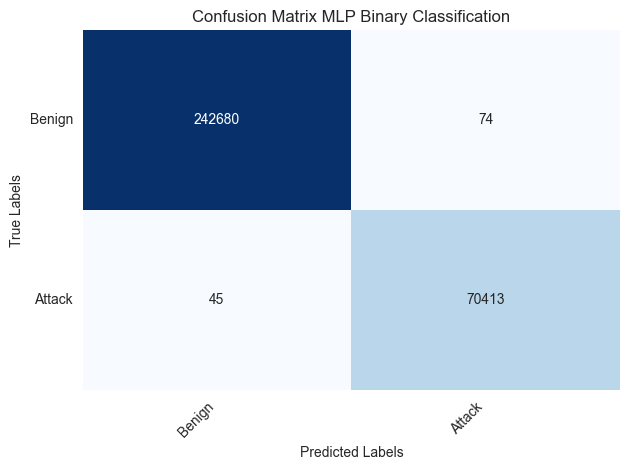

In [13]:
# List of class labels in the correct order
labels = [
    'Benign',
    'Attack'
]
cm = confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = cm.ravel()

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=False)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix MLP Binary Classification')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
#export results
#deep learning
results_list = ["mlp_binary", training_time, accuracy, recall, precision, f1, roc_auc, logloss, tn, fp, fn, tp]
file_path = 'results.csv'

# Check if the file exists to avoid duplicate headers
file_exists = os.path.isfile(file_path)

# Open and write to the file
with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    # Write the data row
    writer.writerow(results_list)